## Biblioteca

In [1]:
#!pip install mne
#!pip install mne_bids
#!pip install openneuro-py
#!pip install dash
#!pip install dash-bootstrap-components
#!pip install captum
import openneuro
from mne_bids import BIDSPath, read_raw_bids
import os
from mne.datasets import sample
from mne.preprocessing import ICA
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import sample
import pandas as pd
import seaborn as sns
import openneuro
import numpy as np
from numpy.fft import fft, ifft, fftfreq
from mne import make_fixed_length_epochs
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from captum.attr import IntegratedGradients


## Banco de dados

In [2]:

# Definir o ID do dataset
dataset = "ds002778"

# Definir o diretório onde o dataset será salvo
bids_root = os.path.join(os.path.dirname(sample.data_path()), dataset)

# Criar o diretório, se ele ainda não existir
if not os.path.isdir(bids_root):
    os.makedirs(bids_root)

# Baixar todos os dados do dataset
openneuro.download(dataset=dataset, target_dir=bids_root)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …
Cannot determine local revision of the dataset, and the target directory is not empty. If the download fails, you may want to try again with a fresh (empty) target directory.


📁 Traversing directories for ds002778 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 328 files (5 concurrent downloads). 
✅ Finished downloading ds002778.
 
🧠 Please enjoy your brains.
 


In [3]:
# Diretório base dos dados no formato BIDS
bids_root = '/root/mne_data/ds002778'

# Lista para armazenar os dados carregados
eeg_data = {}

# Iterar pelos participantes
for participant_id in os.listdir(bids_root):
    if participant_id.startswith("sub-"):  # Apenas participantes
        print(f"Carregando dados para {participant_id}...")

        participant_dir = os.path.join(bids_root, participant_id)
        sessions = os.listdir(participant_dir)
        print(f"  Sessões disponíveis: {sessions}")

        try:
            # Verificar o tipo de participante: Grupo Controle (HC) ou Parkinson (PD)
            if "ses-hc" in sessions:  # Grupo Controle
                bids_path_hc = BIDSPath(root=bids_root, subject=participant_id.replace("sub-", ""),
                                        session="hc", task="rest", datatype="eeg", extension=".bdf")
                print(f"  Tentando carregar: {bids_path_hc}")
                if bids_path_hc.fpath.exists():
                    raw_hc = read_raw_bids(bids_path_hc)
                    eeg_data[f"{participant_id}_hc"] = raw_hc
                    print(f"  Dados carregados para {participant_id} - HC.")
                else:
                    print(f"  Arquivo não encontrado para {participant_id} - HC.")

            elif "ses-on" in sessions and "ses-off" in sessions:  # Grupo Parkinson
                # Carregar estado OFF
                bids_path_off = BIDSPath(root=bids_root, subject=participant_id.replace("sub-", ""),
                                         session="off", task="rest", datatype="eeg", extension=".bdf")
                print(f"  Tentando carregar: {bids_path_off}")
                if bids_path_off.fpath.exists():
                    raw_off = read_raw_bids(bids_path_off)
                    eeg_data[f"{participant_id}_off"] = raw_off
                    print(f"  Dados carregados para {participant_id} - OFF.")
                else:
                    print(f"  Arquivo não encontrado para {participant_id} - OFF.")

                # Carregar estado ON
                bids_path_on = BIDSPath(root=bids_root, subject=participant_id.replace("sub-", ""),
                                        session="on", task="rest", datatype="eeg", extension=".bdf")
                print(f"  Tentando carregar: {bids_path_on}")
                if bids_path_on.fpath.exists():
                    raw_on = read_raw_bids(bids_path_on)
                    eeg_data[f"{participant_id}_on"] = raw_on
                    print(f"  Dados carregados para {participant_id} - ON.")
                else:
                    print(f"  Arquivo não encontrado para {participant_id} - ON.")

        except Exception as e:
            print(f"Erro ao carregar dados para {participant_id}: {str(e)}")

print(f"Carregamento de dados concluído! Total de participantes carregados: {len(eeg_data)}")


Carregando dados para sub-hc1...
  Sessões disponíveis: ['ses-hc']
  Tentando carregar: /root/mne_data/ds002778/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc1 - HC.
Carregando dados para sub-hc21...
  Sessões disponíveis: ['ses-hc']
  Tentando carregar: /root/mne_data/ds002778/sub-hc21/ses-hc/eeg/sub-hc21_ses-hc_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-hc21/ses-hc/eeg/sub-hc21_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Cr

<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 48
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 28
NAART: 33
disease_duration: n/a
rl_deficits: n/a
notes: Subject was missing reading glasses
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 57
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 26
NAART: 53
disease_duration: 1
rl_deficits: n/a
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to M

Reading channel info from /root/mne_data/ds002778/sub-pd6/ses-on/eeg/sub-pd6_ses-on_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-pd6 - ON.
Carregando dados para sub-hc2...
  Sessões disponíveis: ['ses-hc']
  Tentando carregar: /root/mne_data/ds002778/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc2 - HC.
Carregando dados para sub-pd16...
  Sessões disponíveis: ['ses-on', 'ses-off']
  Tentando carregar: /root/mne_data/ds002778

<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 42
disease_duration: 8
rl_deficits: L OFF meds, more R ON meds
notes: Used preprocessed data from EEGLAB .mat file instead of raw data for pd on
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 55
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 29
NAART: 56
disease_duration: 2
rl_deficits: Started on left, noticed left side worse
notes: Used preprocessed data from EEGLAB .mat file instead of raw data for pd on
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 29
NAART: 56
disease_duration:

  Dados carregados para sub-pd22 - ON.
Carregando dados para sub-pd26...
  Sessões disponíveis: ['ses-on', 'ses-off']
  Tentando carregar: /root/mne_data/ds002778/sub-pd26/ses-off/eeg/sub-pd26_ses-off_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-pd26/ses-off/eeg/sub-pd26_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-pd26/ses-off/eeg/sub-pd26_ses-off_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-pd26/ses-off/eeg/sub-pd26_ses-off_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-pd26 - OFF.
  Tentando carregar: /root/mne_data/ds002778/sub-pd26/ses-on/eeg/sub-pd26_ses-on_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-pd26/ses-on/eeg/sub-pd26_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
C

<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 30
NAART: 51
disease_duration: 6
rl_deficits: started on Left side, left is worse
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 51
disease_duration: 3
rl_deficits: started L leg tremor, then moved to right arm tremor, but left leg stopped
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 51
disease_duration: 3
rl_deficits: started L leg tremor, then moved to right arm tremor, but left leg stopped
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 29
NAART: 47
disease_duration: 2
rl_deficits: R slightly wor

Reading events from /root/mne_data/ds002778/sub-hc10/ses-hc/eeg/sub-hc10_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc10/ses-hc/eeg/sub-hc10_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc10 - HC.
Carregando dados para sub-hc4...
  Sessões disponíveis: ['ses-hc']
  Tentando carregar: /root/mne_data/ds002778/sub-hc4/ses-hc/eeg/sub-hc4_ses-hc_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-hc4/ses-hc/eeg/sub-hc4_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-hc4/ses-hc/eeg/sub-hc4_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc4/ses-hc/eeg/sub-hc4_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc4 - HC.
Carregando dados p

<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 51
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 52
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 28
NAART: 50
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 29
NAART: 46
disease_duration: 9
rl_deficits: started on right, but left is worse
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to M

Reading channel info from /root/mne_data/ds002778/sub-hc8/ses-hc/eeg/sub-hc8_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc8 - HC.
Carregando dados para sub-pd3...
  Sessões disponíveis: ['ses-on', 'ses-off']
  Tentando carregar: /root/mne_data/ds002778/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-pd3 - OFF.
  Tentando carregar: /root/mne_data/ds002778/sub-pd3/ses-on/eeg/sub-pd3_ses-on_task-rest_eeg.bdf
Extrac

<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 41
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 44
disease_duration: 9
rl_deficits: R
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 44
disease_duration: 9
rl_deficits: R
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 30
NAART: 58
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 52
disea

Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-pd11/ses-on/eeg/sub-pd11_ses-on_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-pd11/ses-on/eeg/sub-pd11_ses-on_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-pd11 - ON.
Carregando dados para sub-pd5...
  Sessões disponíveis: ['ses-on', 'ses-off']
  Tentando carregar: /root/mne_data/ds002778/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dado

<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 52
disease_duration: 1
rl_deficits: R worse off
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 48
disease_duration: 2
rl_deficits: No clear side, perhaps more L
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 48
disease_duration: 2
rl_deficits: No clear side, perhaps more L
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 28
NAART: 35
disease_duration: 2
rl_deficits: R worse off
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc7 - HC.
Carregando dados para sub-hc25...
  Sessões disponíveis: ['ses-hc']
  Tentando carregar: /root/mne_data/ds002778/sub-hc25/ses-hc/eeg/sub-hc25_ses-hc_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-hc25/ses-hc/eeg/sub-hc25_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-hc25/ses-hc/eeg/sub-hc25_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc25/ses-hc/eeg/sub-hc25_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keep

<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 26
NAART: 48
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 49
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 28
NAART: 50
disease_duration: 12
rl_deficits: R
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 28
NAART: 50
disease_duration: 12
rl_deficits: R
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 29
NAART: 37
dis

Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-pd19/ses-off/eeg/sub-pd19_ses-off_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-pd19/ses-off/eeg/sub-pd19_ses-off_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-pd19 - OFF.
  Tentando carregar: /root/mne_data/ds002778/sub-pd19/ses-on/eeg/sub-pd19_ses-on_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-pd19/ses-on/eeg/sub-pd19_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-pd19/ses-on/eeg/sub-pd19_ses-on_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-pd19/ses-on/eeg/sub-pd19_ses-on_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-pd19 - ON.
Carregando dados para sub-pd23...
  Sess

<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 43
disease_duration: 6
rl_deficits: started on Left side, left is worse
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 43
disease_duration: 6
rl_deficits: started on Left side, left is worse
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 34
disease_duration: 3
rl_deficits: started on L, left is worse
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 34
disease_duration: 3
rl_deficits: started on L, left is worse
notes: n/a
  raw_on = read_raw_bids(bids_path_on)
<ipython-input-3-6b5

Reading events from /root/mne_data/ds002778/sub-hc29/ses-hc/eeg/sub-hc29_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc29/ses-hc/eeg/sub-hc29_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc29 - HC.
Carregando dados para sub-hc33...
  Sessões disponíveis: ['ses-hc']
  Tentando carregar: /root/mne_data/ds002778/sub-hc33/ses-hc/eeg/sub-hc33_ses-hc_task-rest_eeg.bdf
Extracting EDF parameters from /root/mne_data/ds002778/sub-hc33/ses-hc/eeg/sub-hc33_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /root/mne_data/ds002778/sub-hc33/ses-hc/eeg/sub-hc33_ses-hc_task-rest_events.tsv.
Reading channel info from /root/mne_data/ds002778/sub-hc33/ses-hc/eeg/sub-hc33_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
  Dados carregados para sub-hc33 - HC.
Carregan

<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 29
NAART: 45
disease_duration: n/a
rl_deficits: n/a
notes: Claims to have dyslexia, and history of slower reaction times
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 30
NAART: 53
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:23: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 30
NAART: 57
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw_hc = read_raw_bids(bids_path_hc)
<ipython-input-3-6b5ca0f3824d>:35: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: m
MMSE: 30
NAART: 40
disease_duration: 2
rl_deficits: started on R; Right slightly worse
notes: n/a
  raw_off = read_raw_bids(bids_path_off)
<ipython-input-3-6b5ca0f3824d>:46: Runt

In [4]:
# Extrair IDs únicos dos pacientes
unique_patients = set(participant.split("_")[0] for participant in eeg_data.keys())

# Contar o número total de pacientes únicos
total_unique_patients = len(unique_patients)

# Exibir os IDs únicos e o número total de pacientes únicos
print("Pacientes únicos carregados:")
for patient in unique_patients:
    print(patient)
print(f"\nTotal de pacientes únicos: {total_unique_patients}")

Pacientes únicos carregados:
sub-hc33
sub-hc30
sub-hc1
sub-hc7
sub-pd28
sub-hc32
sub-hc24
sub-pd5
sub-pd6
sub-pd3
sub-hc2
sub-pd16
sub-pd22
sub-hc4
sub-hc18
sub-pd17
sub-pd14
sub-hc20
sub-pd9
sub-hc25
sub-pd26
sub-hc21
sub-pd19
sub-hc10
sub-hc8
sub-pd23
sub-pd11
sub-hc31
sub-pd12
sub-hc29
sub-pd13

Total de pacientes únicos: 31


## Pré-processamento


#### Aplicar filtro Notch para remover ruídos de linha elétrica.

In [5]:
# Frequências para o filtro Notch (60 Hz e 120 Hz)
notch_freqs = [60, 120]

# Iterar pelos dados carregados
for participant, raw_data in eeg_data.items():
    try:
        print(f"Carregando dados para {participant} na memória...")
        raw_data.load_data()  # Carregar dados na memória

        print(f"Aplicando filtro Notch para {participant}...")
        raw_notch = raw_data.notch_filter(freqs=notch_freqs)
        eeg_data[participant] = raw_notch  # Atualizar os dados no dicionário

        print(f"Filtro Notch aplicado para {participant}.")
    except Exception as e:
        print(f"Erro ao aplicar filtro Notch para {participant}: {e}")

print("Filtro Notch aplicado a todos os participantes.")


Carregando dados para sub-hc1_hc na memória...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
Aplicando filtro Notch para sub-hc1_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc1_hc.
Carregando dados para sub-hc21_hc na memória...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc21_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc21_hc.
Carregando dados para sub-hc24_hc na memória...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc24_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc24_hc.
Carregando dados para sub-pd12_off na memória...
Reading 0 ... 105983  =      0.000 ...   206.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd12_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd12_off.
Carregando dados para sub-pd12_on na memória...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
Aplicando filtro Notch para sub-pd12_on...
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd12_on.
Carregando dados para sub-pd6_off na memória...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd6_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd6_off.
Carregando dados para sub-pd6_on na memória...
Reading 0 ... 147967  =      0.000 ...   288.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd6_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd6_on.
Carregando dados para sub-hc2_hc na memória...
Reading 0 ... 99327  =      0.000 ...   193.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc2_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc2_hc.
Carregando dados para sub-pd16_off na memória...
Reading 0 ... 96255  =      0.000 ...   187.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd16_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd16_off.
Carregando dados para sub-pd16_on na memória...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd16_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd16_on.
Carregando dados para sub-pd22_off na memória...
Reading 0 ... 96255  =      0.000 ...   187.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd22_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd22_off.
Carregando dados para sub-pd22_on na memória...
Reading 0 ... 94207  =      0.000 ...   183.998 secs...
Aplicando filtro Notch para sub-pd22_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd22_on.
Carregando dados para sub-pd26_off na memória...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
Aplicando filtro Notch para sub-pd26_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd26_off.
Carregando dados para sub-pd26_on na memória...
Reading 0 ... 110591  =      0.000 ...   215.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd26_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd26_on.
Carregando dados para sub-pd13_off na memória...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd13_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd13_off.
Carregando dados para sub-pd13_on na memória...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd13_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd13_on.
Carregando dados para sub-hc10_hc na memória...
Reading 0 ... 102911  =      0.000 ...   200.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc10_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc10_hc.
Carregando dados para sub-hc4_hc na memória...
Reading 0 ... 92671  =      0.000 ...   180.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc4_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc4_hc.
Carregando dados para sub-hc31_hc na memória...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc31_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc31_hc.
Carregando dados para sub-pd28_off na memória...
Reading 0 ... 105471  =      0.000 ...   205.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd28_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd28_off.
Carregando dados para sub-pd28_on na memória...
Reading 0 ... 102911  =      0.000 ...   200.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd28_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd28_on.
Carregando dados para sub-hc8_hc na memória...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc8_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc8_hc.
Carregando dados para sub-pd3_off na memória...
Reading 0 ... 102399  =      0.000 ...   199.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd3_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd3_off.
Carregando dados para sub-pd3_on na memória...
Reading 0 ... 109055  =      0.000 ...   212.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd3_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd3_on.
Carregando dados para sub-hc20_hc na memória...
Reading 0 ... 94207  =      0.000 ...   183.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc20_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc20_hc.
Carregando dados para sub-pd11_off na memória...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd11_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd11_off.
Carregando dados para sub-pd11_on na memória...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd11_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd11_on.
Carregando dados para sub-pd5_off na memória...
Reading 0 ... 100863  =      0.000 ...   196.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd5_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd5_off.
Carregando dados para sub-pd5_on na memória...
Reading 0 ... 105471  =      0.000 ...   205.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd5_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd5_on.
Carregando dados para sub-pd14_off na memória...
Reading 0 ... 149503  =      0.000 ...   291.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd14_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro Notch aplicado para sub-pd14_off.
Carregando dados para sub-pd14_on na memória...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...
Aplicando filtro Notch para sub-pd14_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd14_on.
Carregando dados para sub-hc7_hc na memória...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc7_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc7_hc.
Carregando dados para sub-hc25_hc na memória...
Reading 0 ... 103423  =      0.000 ...   201.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc25_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc25_hc.
Carregando dados para sub-pd9_off na memória...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd9_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd9_off.
Carregando dados para sub-pd9_on na memória...
Reading 0 ... 95743  =      0.000 ...   186.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd9_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro Notch aplicado para sub-pd9_on.
Carregando dados para sub-hc32_hc na memória...
Reading 0 ... 100351  =      0.000 ...   195.998 secs...
Aplicando filtro Notch para sub-hc32_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtro Notch aplicado para sub-hc32_hc.
Carregando dados para sub-pd19_off na memória...
Reading 0 ... 94719  =      0.000 ...   184.998 secs...
Aplicando filtro Notch para sub-pd19_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd19_off.
Carregando dados para sub-pd19_on na memória...
Reading 0 ... 96255  =      0.000 ...   187.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd19_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd19_on.
Carregando dados para sub-pd23_off na memória...
Reading 0 ... 104447  =      0.000 ...   203.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd23_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd23_off.
Carregando dados para sub-pd23_on na memória...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd23_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd23_on.
Carregando dados para sub-hc30_hc na memória...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc30_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc30_hc.
Carregando dados para sub-hc29_hc na memória...
Reading 0 ... 101887  =      0.000 ...   198.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc29_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc29_hc.
Carregando dados para sub-hc33_hc na memória...
Reading 0 ... 97279  =      0.000 ...   189.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc33_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc33_hc.
Carregando dados para sub-hc18_hc na memória...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-hc18_hc...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-hc18_hc.
Carregando dados para sub-pd17_off na memória...
Reading 0 ... 96767  =      0.000 ...   188.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd17_off...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd17_off.
Carregando dados para sub-pd17_on na memória...
Reading 0 ... 95231  =      0.000 ...   185.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Aplicando filtro Notch para sub-pd17_on...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)

Filtro Notch aplicado para sub-pd17_on.
Filtro Notch aplicado a todos os participantes.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


#### Passa-Banda

In [12]:
# Definir os limites do filtro passa-banda
low_freq = 0.5  # Limite inferior
high_freq = 50  # Limite superior

# Aplicar o filtro para cada conjunto de dados
for participant_id, raw_data in eeg_data.items():
    try:
        print(f"Aplicando filtro passa-banda ({low_freq}-{high_freq} Hz) para {participant_id}...")

        # Certificar-se de que os dados estão na memória
        raw_data.load_data()

        # Aplicar o filtro passa-banda
        raw_filtered = raw_data.filter(l_freq=low_freq, h_freq=high_freq)

        # Substituir os dados antigos pelos filtrados no dicionário
        eeg_data[participant_id] = raw_filtered
        print(f"Filtro passa-banda aplicado para {participant_id}.")

    except Exception as e:
        print(f"Erro ao aplicar filtro passa-banda para {participant_id}: {e}")

print("Filtro passa-banda aplicado a todos os participantes.")

Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc1_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-hc1_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc21_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc21_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc24_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc24_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd12_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd12_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd12_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd12_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd6_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd6_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd6_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd6_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc2_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtro passa-banda aplicado para sub-hc2_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd16_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd16_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd16_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-pd16_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd22_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd22_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd22_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-pd22_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd26_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd26_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd26_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd26_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd13_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd13_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd13_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd13_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc10_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-hc10_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc4_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc4_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc31_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc31_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd28_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-pd28_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd28_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd28_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc8_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-hc8_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd3_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd3_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd3_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd3_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc20_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc20_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd11_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd11_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd11_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-pd11_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd5_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd5_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd5_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd5_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd14_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd14_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd14_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd14_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc7_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc7_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc25_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc25_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd9_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd9_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd9_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-pd9_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc32_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc32_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd19_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd19_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd19_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd19_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd23_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-pd23_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd23_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd23_on.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc30_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-hc30_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc29_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc29_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc33_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-hc33_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-hc18_hc...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-hc18_hc.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd17_off...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro passa-banda aplicado para sub-pd17_off.
Aplicando filtro passa-banda (0.5-50 Hz) para sub-pd17_on...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Filtro passa-banda aplicado para sub-pd17_on.
Filtro passa-banda aplicado a todos os participantes.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


#### Verificação dos Dados Pós-Filtro

In [7]:


# Diretório temporário para salvar os gráficos
output_dir = "/mnt/data/output_graphics"
os.makedirs(output_dir, exist_ok=True)

# Função para verificar o sinal e a PSD e salvar os gráficos
def verificar_sinal_psd_salvar(raw_data, title, save_path):
    # Garantir que o diretório de salvamento existe
    os.makedirs(save_path, exist_ok=True)

    # Visualizar e salvar o sinal de EEG
    signal_path = os.path.join(save_path, f"{title.replace(' ', '_')}_signal.png")
    plt.figure(figsize=(15, 5))
    raw_data.plot(start=0, duration=10, n_channels=10, title=title, show=False)
    plt.savefig(signal_path, dpi=300)
    plt.close()

    # Visualizar e salvar a PSD
    psd_path = os.path.join(save_path, f"{title.replace(' ', '_')}_psd.png")
    plt.figure(figsize=(10, 5))
    raw_data.plot_psd(fmin=0.5, fmax=50, average=True, show=False)
    plt.title(f"PSD: {title}")
    plt.savefig(psd_path, dpi=300)
    plt.close()

    return signal_path, psd_path

# Simulação de estrutura de `eeg_data` e exemplo de uso
try:

    # Criar um dicionário para análise
    samples = {
        "PD_OFF - sub-pd17_off": eeg_data["sub-pd17_off"],
        "PD_ON - sub-pd17_on": eeg_data["sub-pd17_on"],
        "HC - sub-hc24_hc": eeg_data["sub-hc24_hc"]
    }

    # Verificar os dados e salvar gráficos
    saved_files = []
    for group, raw in samples.items():
        print(f"Salvando gráficos para {group}...")
        files = verificar_sinal_psd_salvar(raw, f"Sinal e PSD - {group}", save_path=output_dir)
        saved_files.extend(files)

    print("Gráficos salvos nos seguintes arquivos:")
    for file in saved_files:
        print(file)

except Exception as e:
    print(f"Erro ao processar os dados: {e}")

Salvando gráficos para PD_OFF - sub-pd17_off...
Using matplotlib as 2D backend.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Salvando gráficos para PD_ON - sub-pd17_on...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Salvando gráficos para HC - sub-hc24_hc...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Gráficos salvos nos seguintes arquivos:
/mnt/data/output_graphics/Sinal_e_PSD_-_PD_OFF_-_sub-pd17_off_signal.png
/mnt/data/output_graphics/Sinal_e_PSD_-_PD_OFF_-_sub-pd17_off_psd.png
/mnt/data/output_graphics/Sinal_e_PSD_-_PD_ON_-_sub-pd17_on_signal.png
/mnt/data/output_graphics/Sinal_e_PSD_-_PD_ON_-_sub-pd17_on_psd.png
/mnt/data/output_graphics/Sinal_

<Figure size 1500x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

#### Remoção de artefatos

In [8]:


# Configuração geral de ICA e salvamento dos gráficos
def aplicar_ica_e_salvar_graficos(eeg_data, channels_to_remove, output_dir, montage_type="standard_1020"):
    dados_limpos = {}
    montage = make_standard_montage(montage_type)  # Configurar montagem padrão

    # Criar diretório de saída, se não existir
    os.makedirs(output_dir, exist_ok=True)

    for participant_id, raw_data in eeg_data.items():
        try:
            print(f"Iniciando ICA para {participant_id}...")

            # Verificar e remover canais específicos
            raw_data.drop_channels([ch for ch in channels_to_remove if ch in raw_data.info['ch_names']])

            # Aplicar montagem e carregar dados na memória
            raw_data.set_montage(montage)
            raw_data.load_data()

            # Configurar ICA
            ica = ICA(n_components=20, random_state=42, max_iter='auto')

            # Ajustar ICA aos dados filtrados
            print(f"Ajustando ICA para {participant_id}...")
            ica.fit(raw_data.copy().pick_types(eeg=True))

            # Identificar artefatos relacionados a EOG usando o canal frontal (Fp1)
            print(f"Identificando artefatos relacionados a EOG para {participant_id}...")
            eog_indices, eog_scores = ica.find_bads_eog(raw_data, ch_name='Fp1')

            # Exibir os índices dos componentes relacionados a EOG
            print(f"Componentes relacionados a EOG para {participant_id}: {eog_indices}")

            # Marcar os componentes identificados para exclusão
            ica.exclude = eog_indices

            # Aplicar ICA para limpar os dados
            print(f"Aplicando ICA para limpar os dados de {participant_id}...")
            raw_cleaned = ica.apply(raw_data.copy())

            # Adicionar dados limpos ao dicionário
            dados_limpos[participant_id] = raw_cleaned

            # Criar diretório específico para o participante
            participant_dir = os.path.join(output_dir, participant_id)
            os.makedirs(participant_dir, exist_ok=True)

            # Salvar o gráfico dos componentes ICA
            plot_path = os.path.join(participant_dir, f"{participant_id}_ica_components.png")
            print(f"Salvando gráfico de componentes ICA para {participant_id} em {plot_path}...")
            ica.plot_components(show=False)
            plt.savefig(plot_path)
            plt.close()

            print(f"ICA aplicada e gráfico salvo com sucesso para {participant_id}.\n")
        except Exception as e:
            print(f"Erro ao processar {participant_id}: {e}")

    return dados_limpos

# Lista de canais a serem removidos
channels_to_remove = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

# Diretório para salvar os gráficos
output_dir = "/mnt/data/ica_plots"

# Aplicar ICA para todos os participantes e salvar gráficos
dados_limpos = aplicar_ica_e_salvar_graficos(eeg_data, channels_to_remove, output_dir)

Iniciando ICA para sub-hc1_hc...
Ajustando ICA para sub-hc1_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
Identificando artefatos relacionados a EOG para sub-hc1_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-hc1_hc: [0]
Aplicando ICA para limpar os dados de sub-hc1_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc1_hc em /mnt/data/ica_plots/sub-hc1_hc/sub-hc1_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc1_hc.

Iniciando ICA para sub-hc21_hc...
Ajustando ICA para sub-hc21_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.2s.
Identificando artefatos relacionados a EOG para sub-hc21_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Salvando gráfico de componentes ICA para sub-hc21_hc em /mnt/data/ica_plots/sub-hc21_hc/sub-hc21_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc21_hc.

Iniciando ICA para sub-hc24_hc...
Ajustando ICA para sub-hc24_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.2s.
Identificando artefatos relacionados a EOG para sub-hc24_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc24_hc em /mnt/data/ica_plots/sub-hc24_hc/sub-hc24_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc24_hc.

Iniciando ICA para sub-pd12_off...
Ajustando ICA para sub-pd12_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
Identificando artefatos relacionados a EOG para sub-pd12_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Uppe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd12_off em /mnt/data/ica_plots/sub-pd12_off/sub-pd12_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd12_off.

Iniciando ICA para sub-pd12_on...
Ajustando ICA para sub-pd12_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.
Identificando artefatos relacionados a EOG para sub-pd12_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd12_on: [0]
Aplicando ICA para limpar os dados de sub-pd12_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd12_on em /mnt/data/ica_plots/sub-pd12_on/sub-pd12_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd12_on.

Iniciando ICA para sub-pd6_off...
Ajustando ICA para sub-pd6_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.4s.
Identificando artefatos relacionados a EOG para sub-pd6_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Salvando gráfico de componentes ICA para sub-pd6_off em /mnt/data/ica_plots/sub-pd6_off/sub-pd6_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd6_off.

Iniciando ICA para sub-pd6_on...
Ajustando ICA para sub-pd6_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.5s.
Identificando artefatos relacionados a EOG para sub-pd6_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff fre

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd6_on: [0]
Aplicando ICA para limpar os dados de sub-pd6_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd6_on em /mnt/data/ica_plots/sub-pd6_on/sub-pd6_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd6_on.

Iniciando ICA para sub-hc2_hc...
Ajustando ICA para sub-hc2_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 42.0s.
Identificando artefatos relacionados a EOG para sub-hc2_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- W

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Componentes relacionados a EOG para sub-hc2_hc: [0]
Aplicando ICA para limpar os dados de sub-hc2_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc2_hc em /mnt/data/ica_plots/sub-hc2_hc/sub-hc2_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc2_hc.

Iniciando ICA para sub-pd16_off...
Ajustando ICA para sub-pd16_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.4s.
Identificando artefatos relacionados a EOG para sub-pd16_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper pa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd16_off em /mnt/data/ica_plots/sub-pd16_off/sub-pd16_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd16_off.

Iniciando ICA para sub-pd16_on...
Ajustando ICA para sub-pd16_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.2s.
Identificando artefatos relacionados a EOG para sub-pd16_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd16_on: [0]
Aplicando ICA para limpar os dados de sub-pd16_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd16_on em /mnt/data/ica_plots/sub-pd16_on/sub-pd16_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd16_on.

Iniciando ICA para sub-pd22_off...
Ajustando ICA para sub-pd22_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.4s.
Identificando artefatos relacionados a EOG para sub-pd22_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd22_off: [0]
Aplicando ICA para limpar os dados de sub-pd22_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd22_off em /mnt/data/ica_plots/sub-pd22_off/sub-pd22_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd22_off.

Iniciando ICA para sub-pd22_on...
Ajustando ICA para sub-pd22_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 38.0s.
Identificando artefatos relacionados a EOG para sub-pd22_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandp

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd22_on: [0]
Aplicando ICA para limpar os dados de sub-pd22_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd22_on em /mnt/data/ica_plots/sub-pd22_on/sub-pd22_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd22_on.

Iniciando ICA para sub-pd26_off...
Ajustando ICA para sub-pd26_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.3s.
Identificando artefatos relacionados a EOG para sub-pd26_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd26_off em /mnt/data/ica_plots/sub-pd26_off/sub-pd26_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd26_off.

Iniciando ICA para sub-pd26_on...
Ajustando ICA para sub-pd26_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.5s.
Identificando artefatos relacionados a EOG para sub-pd26_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd26_on: [0]
Aplicando ICA para limpar os dados de sub-pd26_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd26_on em /mnt/data/ica_plots/sub-pd26_on/sub-pd26_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd26_on.

Iniciando ICA para sub-pd13_off...
Ajustando ICA para sub-pd13_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
Identificando artefatos relacionados a EOG para sub-pd13_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd13_off: [0]
Aplicando ICA para limpar os dados de sub-pd13_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd13_off em /mnt/data/ica_plots/sub-pd13_off/sub-pd13_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd13_off.

Iniciando ICA para sub-pd13_on...
Ajustando ICA para sub-pd13_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
Identificando artefatos relacionados a EOG para sub-pd13_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd13_on em /mnt/data/ica_plots/sub-pd13_on/sub-pd13_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd13_on.

Iniciando ICA para sub-hc10_hc...
Ajustando ICA para sub-hc10_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.1s.
Identificando artefatos relacionados a EOG para sub-hc10_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-hc10_hc: [0]
Aplicando ICA para limpar os dados de sub-hc10_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc10_hc em /mnt/data/ica_plots/sub-hc10_hc/sub-hc10_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc10_hc.

Iniciando ICA para sub-hc4_hc...
Ajustando ICA para sub-hc4_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 69.5s.
Identificando artefatos relacionados a EOG para sub-hc4_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filte

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-hc4_hc: [0]
Aplicando ICA para limpar os dados de sub-hc4_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc4_hc em /mnt/data/ica_plots/sub-hc4_hc/sub-hc4_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc4_hc.

Iniciando ICA para sub-hc31_hc...
Ajustando ICA para sub-hc31_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.2s.
Identificando artefatos relacionados a EOG para sub-hc31_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-hc31_hc: [1]
Aplicando ICA para limpar os dados de sub-hc31_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc31_hc em /mnt/data/ica_plots/sub-hc31_hc/sub-hc31_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc31_hc.

Iniciando ICA para sub-pd28_off...
Ajustando ICA para sub-pd28_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.4s.
Identificando artefatos relacionados a EOG para sub-pd28_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd28_off: [0, 1]
Aplicando ICA para limpar os dados de sub-pd28_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd28_off em /mnt/data/ica_plots/sub-pd28_off/sub-pd28_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd28_off.

Iniciando ICA para sub-pd28_on...
Ajustando ICA para sub-pd28_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.9s.
Identificando artefatos relacionados a EOG para sub-pd28_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd28_on em /mnt/data/ica_plots/sub-pd28_on/sub-pd28_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd28_on.

Iniciando ICA para sub-hc8_hc...
Ajustando ICA para sub-hc8_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 12.1s.
Identificando artefatos relacionados a EOG para sub-hc8_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-hc8_hc: [0]
Aplicando ICA para limpar os dados de sub-hc8_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc8_hc em /mnt/data/ica_plots/sub-hc8_hc/sub-hc8_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc8_hc.

Iniciando ICA para sub-pd3_off...
Ajustando ICA para sub-pd3_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.8s.
Identificando artefatos relacionados a EOG para sub-pd3_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd3_off em /mnt/data/ica_plots/sub-pd3_off/sub-pd3_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd3_off.

Iniciando ICA para sub-pd3_on...
Ajustando ICA para sub-pd3_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.4s.
Identificando artefatos relacionados a EOG para sub-pd3_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper pass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd3_on: [0]
Aplicando ICA para limpar os dados de sub-pd3_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd3_on em /mnt/data/ica_plots/sub-pd3_on/sub-pd3_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd3_on.

Iniciando ICA para sub-hc20_hc...
Ajustando ICA para sub-hc20_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.7s.
Identificando artefatos relacionados a EOG para sub-hc20_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-hc20_hc: []
Aplicando ICA para limpar os dados de sub-hc20_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc20_hc em /mnt/data/ica_plots/sub-hc20_hc/sub-hc20_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc20_hc.

Iniciando ICA para sub-pd11_off...
Ajustando ICA para sub-pd11_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.1s.
Identificando artefatos relacionados a EOG para sub-pd11_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd11_off em /mnt/data/ica_plots/sub-pd11_off/sub-pd11_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd11_off.

Iniciando ICA para sub-pd11_on...
Ajustando ICA para sub-pd11_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
Identificando artefatos relacionados a EOG para sub-pd11_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd11_on: [0]
Aplicando ICA para limpar os dados de sub-pd11_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd11_on em /mnt/data/ica_plots/sub-pd11_on/sub-pd11_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd11_on.

Iniciando ICA para sub-pd5_off...
Ajustando ICA para sub-pd5_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.2s.
Identificando artefatos relacionados a EOG para sub-pd5_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd5_off: [0]
Aplicando ICA para limpar os dados de sub-pd5_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd5_off em /mnt/data/ica_plots/sub-pd5_off/sub-pd5_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd5_off.

Iniciando ICA para sub-pd5_on...
Ajustando ICA para sub-pd5_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.1s.
Identificando artefatos relacionados a EOG para sub-pd5_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd5_on: [0]
Aplicando ICA para limpar os dados de sub-pd5_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd5_on em /mnt/data/ica_plots/sub-pd5_on/sub-pd5_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd5_on.

Iniciando ICA para sub-pd14_off...
Ajustando ICA para sub-pd14_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.9s.
Identificando artefatos relacionados a EOG para sub-pd14_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd14_off: [0]
Aplicando ICA para limpar os dados de sub-pd14_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd14_off em /mnt/data/ica_plots/sub-pd14_off/sub-pd14_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd14_off.

Iniciando ICA para sub-pd14_on...
Ajustando ICA para sub-pd14_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.
Identificando artefatos relacionados a EOG para sub-pd14_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd14_on: [0]
Aplicando ICA para limpar os dados de sub-pd14_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd14_on em /mnt/data/ica_plots/sub-pd14_on/sub-pd14_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd14_on.

Iniciando ICA para sub-hc7_hc...
Ajustando ICA para sub-hc7_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.3s.
Identificando artefatos relacionados a EOG para sub-hc7_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-hc7_hc: [0]
Aplicando ICA para limpar os dados de sub-hc7_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc7_hc em /mnt/data/ica_plots/sub-hc7_hc/sub-hc7_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc7_hc.

Iniciando ICA para sub-hc25_hc...
Ajustando ICA para sub-hc25_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Identificando artefatos relacionados a EOG para sub-hc25_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc25_hc em /mnt/data/ica_plots/sub-hc25_hc/sub-hc25_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc25_hc.

Iniciando ICA para sub-pd9_off...
Ajustando ICA para sub-pd9_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Identificando artefatos relacionados a EOG para sub-pd9_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd9_off: [0, 3]
Aplicando ICA para limpar os dados de sub-pd9_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd9_off em /mnt/data/ica_plots/sub-pd9_off/sub-pd9_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd9_off.

Iniciando ICA para sub-pd9_on...
Ajustando ICA para sub-pd9_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.
Identificando artefatos relacionados a EOG para sub-pd9_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd9_on em /mnt/data/ica_plots/sub-pd9_on/sub-pd9_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd9_on.

Iniciando ICA para sub-hc32_hc...
Ajustando ICA para sub-hc32_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
Identificando artefatos relacionados a EOG para sub-hc32_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passb

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-hc32_hc: [0]
Aplicando ICA para limpar os dados de sub-hc32_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc32_hc em /mnt/data/ica_plots/sub-hc32_hc/sub-hc32_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc32_hc.

Iniciando ICA para sub-pd19_off...
Ajustando ICA para sub-pd19_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.6s.
Identificando artefatos relacionados a EOG para sub-pd19_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd19_off em /mnt/data/ica_plots/sub-pd19_off/sub-pd19_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd19_off.

Iniciando ICA para sub-pd19_on...
Ajustando ICA para sub-pd19_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.3s.
Identificando artefatos relacionados a EOG para sub-pd19_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Up

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd19_on: [0]
Aplicando ICA para limpar os dados de sub-pd19_on...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd19_on em /mnt/data/ica_plots/sub-pd19_on/sub-pd19_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd19_on.

Iniciando ICA para sub-pd23_off...
Ajustando ICA para sub-pd23_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.8s.
Identificando artefatos relacionados a EOG para sub-pd23_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-pd23_off: [0]
Aplicando ICA para limpar os dados de sub-pd23_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd23_off em /mnt/data/ica_plots/sub-pd23_off/sub-pd23_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd23_off.

Iniciando ICA para sub-pd23_on...
Ajustando ICA para sub-pd23_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.9s.
Identificando artefatos relacionados a EOG para sub-pd23_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd23_on em /mnt/data/ica_plots/sub-pd23_on/sub-pd23_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd23_on.

Iniciando ICA para sub-hc30_hc...
Ajustando ICA para sub-hc30_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.5s.
Identificando artefatos relacionados a EOG para sub-hc30_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc30_hc em /mnt/data/ica_plots/sub-hc30_hc/sub-hc30_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc30_hc.

Iniciando ICA para sub-hc29_hc...
Ajustando ICA para sub-hc29_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.9s.
Identificando artefatos relacionados a EOG para sub-hc29_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc29_hc em /mnt/data/ica_plots/sub-hc29_hc/sub-hc29_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc29_hc.

Iniciando ICA para sub-hc33_hc...
Ajustando ICA para sub-hc33_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.0s.
Identificando artefatos relacionados a EOG para sub-hc33_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc33_hc em /mnt/data/ica_plots/sub-hc33_hc/sub-hc33_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc33_hc.

Iniciando ICA para sub-hc18_hc...
Ajustando ICA para sub-hc18_hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.9s.
Identificando artefatos relacionados a EOG para sub-hc18_hc...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Componentes relacionados a EOG para sub-hc18_hc: [2, 1]
Aplicando ICA para limpar os dados de sub-hc18_hc...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-hc18_hc em /mnt/data/ica_plots/sub-hc18_hc/sub-hc18_hc_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-hc18_hc.

Iniciando ICA para sub-pd17_off...
Ajustando ICA para sub-pd17_off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.2s.
Identificando artefatos relacionados a EOG para sub-pd17_off...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Componentes relacionados a EOG para sub-pd17_off: [0, 1]
Aplicando ICA para limpar os dados de sub-pd17_off...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd17_off em /mnt/data/ica_plots/sub-pd17_off/sub-pd17_off_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd17_off.

Iniciando ICA para sub-pd17_on...
Ajustando ICA para sub-pd17_on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.0s.
Identificando artefatos relacionados a EOG para sub-pd17_on...
Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Salvando gráfico de componentes ICA para sub-pd17_on em /mnt/data/ica_plots/sub-pd17_on/sub-pd17_on_ica_components.png...
ICA aplicada e gráfico salvo com sucesso para sub-pd17_on.



Calculando PSD para a condição on...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

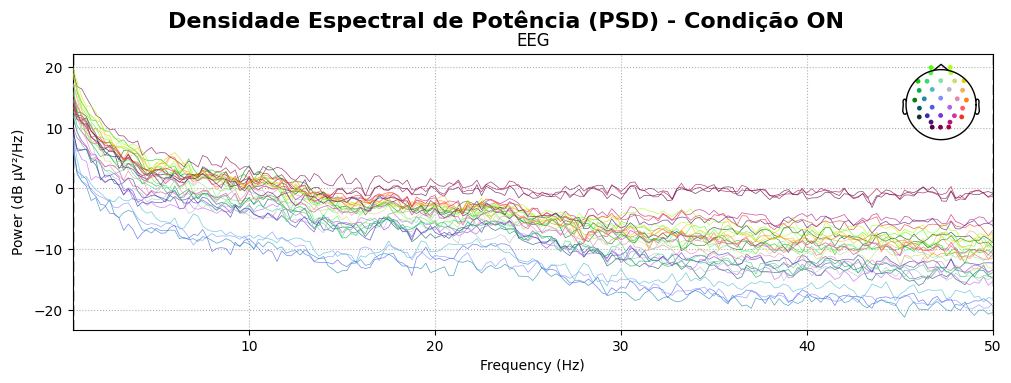

Calculando PSD para a condição off...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

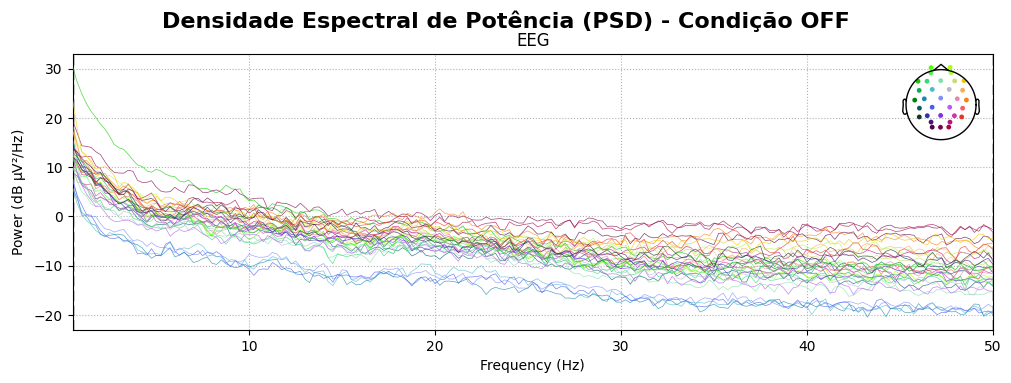

Calculando PSD para a condição hc...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

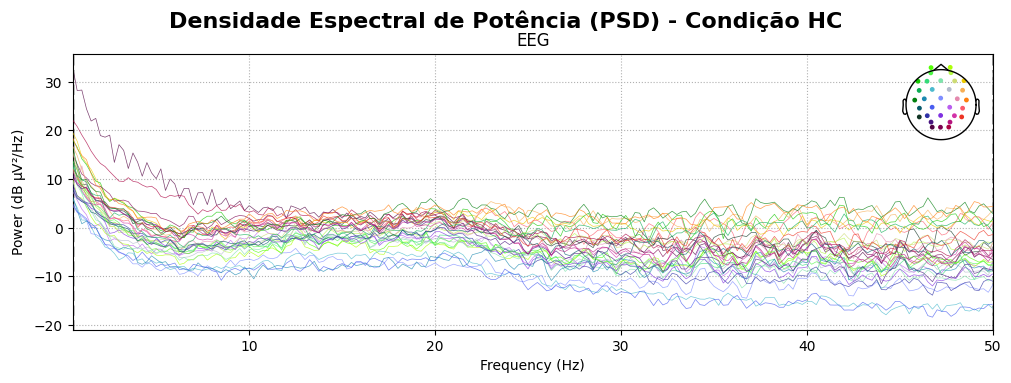

In [30]:
# Identificar os dados limpos para cada condição
psd_on = dados_limpos.get("sub-pd9_on")   # Substitua por identificador correto para condição ON
psd_off = dados_limpos.get("sub-pd9_off") # Substitua por identificador correto para condição OFF
psd_hc = dados_limpos.get("sub-hc31_hc")  # Substitua por identificador correto para HC

# Verificar se os dados estão disponíveis
dados_psd = {
    "on": psd_on,
    "off": psd_off,
    "hc": psd_hc
}

# Iterar pelas condições e calcular o PSD
for condition, dados  in dados_psd.items():
    if dados is not None:
        try:
            print(f"Calculando PSD para a condição {condition}...")

            # Calcular o PSD (com limites de frequência ajustados)
            psd = dados.copy().pick_types(eeg=True).compute_psd(fmin=0.5, fmax=50.0)

            # Plotar o PSD
            plt.clf()  # Limpar gráficos anteriores
            psd.plot()

            # Melhorar o título
            plt.suptitle(f"Densidade Espectral de Potência (PSD) - Condição {condition.upper()}",
                         fontsize=16,
                         fontweight='bold',
                         y=1.05)  # Centralizado e ajustado acima do gráfico

            plt.show()

        except Exception as e:
            print(f"Erro ao calcular ou plotar o PSD para {condition}: {e}")
    else:
        print(f"Dados para a condição '{condition}' não encontrados. Certifique-se de que os dados estão disponíveis.")

## Normalização dos dados limpos

In [31]:
# Função para normalizar os dados (Z-score normalization)
def z_score_normalization(data):


    mean = np.mean(data, axis=1, keepdims=True)  # Média por canal
    std = np.std(data, axis=1, keepdims=True)    # Desvio padrão por canal
    return (data - mean) / std

# Aplicar normalização aos dados limpos
dados_normalizados = {}
for participant_id, raw_cleaned in dados_limpos.items():
    data = raw_cleaned.get_data()  # Extrair os dados em formato de array [n_channels, n_samples]
    normalized_data = z_score_normalization(data)  # Normalizar os dados
    dados_normalizados[participant_id] = normalized_data  # Armazenar os dados normalizados

    print(f"Normalização aplicada para {participant_id}. Dimensões: {normalized_data.shape}")


Normalização aplicada para sub-hc1_hc. Dimensões: (32, 98304)
Normalização aplicada para sub-hc21_hc. Dimensões: (32, 96768)
Normalização aplicada para sub-hc24_hc. Dimensões: (32, 98304)
Normalização aplicada para sub-pd12_off. Dimensões: (32, 105984)
Normalização aplicada para sub-pd12_on. Dimensões: (32, 98304)
Normalização aplicada para sub-pd6_off. Dimensões: (32, 97792)
Normalização aplicada para sub-pd6_on. Dimensões: (32, 147968)
Normalização aplicada para sub-hc2_hc. Dimensões: (32, 99328)
Normalização aplicada para sub-pd16_off. Dimensões: (32, 96256)
Normalização aplicada para sub-pd16_on. Dimensões: (32, 95744)
Normalização aplicada para sub-pd22_off. Dimensões: (32, 96256)
Normalização aplicada para sub-pd22_on. Dimensões: (32, 94208)
Normalização aplicada para sub-pd26_off. Dimensões: (32, 97792)
Normalização aplicada para sub-pd26_on. Dimensões: (32, 110592)
Normalização aplicada para sub-pd13_off. Dimensões: (32, 95232)
Normalização aplicada para sub-pd13_on. Dimensões:

## Segmentação

In [32]:
# Parâmetros de segmentação
segment_duration = 2.0  # Duração de cada segmento em segundos
overlap = 0.2    # Proporção de sobreposição (exemplo: 50%)
sfreq = 256  # Frequência de amostragem (ajuste para os seus dados)

# Função para realizar a segmentação
def segmentar_dados(data, sfreq, segment_duration, overlap):
    n_channels, n_samples = data.shape
    segment_length = int(segment_duration * sfreq)  # Comprimento de cada segmento em pontos
    step = int(segment_length * (1 - overlap))      # Passo entre segmentos

    # Validação do parâmetro 'step'
    if step <= 0:
        raise ValueError("O parâmetro 'overlap' deve ser menor que 1.0.")

    segments = []
    for start in range(0, n_samples - segment_length + 1, step):
        end = start + segment_length
        segments.append(data[:, start:end])

    # Incluir o último segmento, se necessário
    if n_samples % step != 0 and (n_samples - segment_length) % step != 0:
        segments.append(data[:, -segment_length:])

    return np.array(segments)  # [n_segments, n_channels, n_samples_per_segment]

# Aplicar segmentação aos dados normalizados
dados_segmentados = {}
for participant_id, normalized_data in dados_normalizados.items():
    try:
        segmentos = segmentar_dados(normalized_data, sfreq, segment_duration, overlap)
        dados_segmentados[participant_id] = segmentos  # Armazenar os segmentos
        print(f"Segmentação concluída para {participant_id}. Segmentos: {segmentos.shape}")
    except Exception as e:
        print(f"Erro ao processar {participant_id}: {e}")

Segmentação concluída para sub-hc1_hc. Segmentos: (241, 32, 512)
Segmentação concluída para sub-hc21_hc. Segmentos: (237, 32, 512)
Segmentação concluída para sub-hc24_hc. Segmentos: (241, 32, 512)
Segmentação concluída para sub-pd12_off. Segmentos: (259, 32, 512)
Segmentação concluída para sub-pd12_on. Segmentos: (241, 32, 512)
Segmentação concluída para sub-pd6_off. Segmentos: (239, 32, 512)
Segmentação concluída para sub-pd6_on. Segmentos: (362, 32, 512)
Segmentação concluída para sub-hc2_hc. Segmentos: (243, 32, 512)
Segmentação concluída para sub-pd16_off. Segmentos: (236, 32, 512)
Segmentação concluída para sub-pd16_on. Segmentos: (234, 32, 512)
Segmentação concluída para sub-pd22_off. Segmentos: (236, 32, 512)
Segmentação concluída para sub-pd22_on. Segmentos: (231, 32, 512)
Segmentação concluída para sub-pd26_off. Segmentos: (239, 32, 512)
Segmentação concluída para sub-pd26_on. Segmentos: (271, 32, 512)
Segmentação concluída para sub-pd13_off. Segmentos: (233, 32, 512)
Segmenta

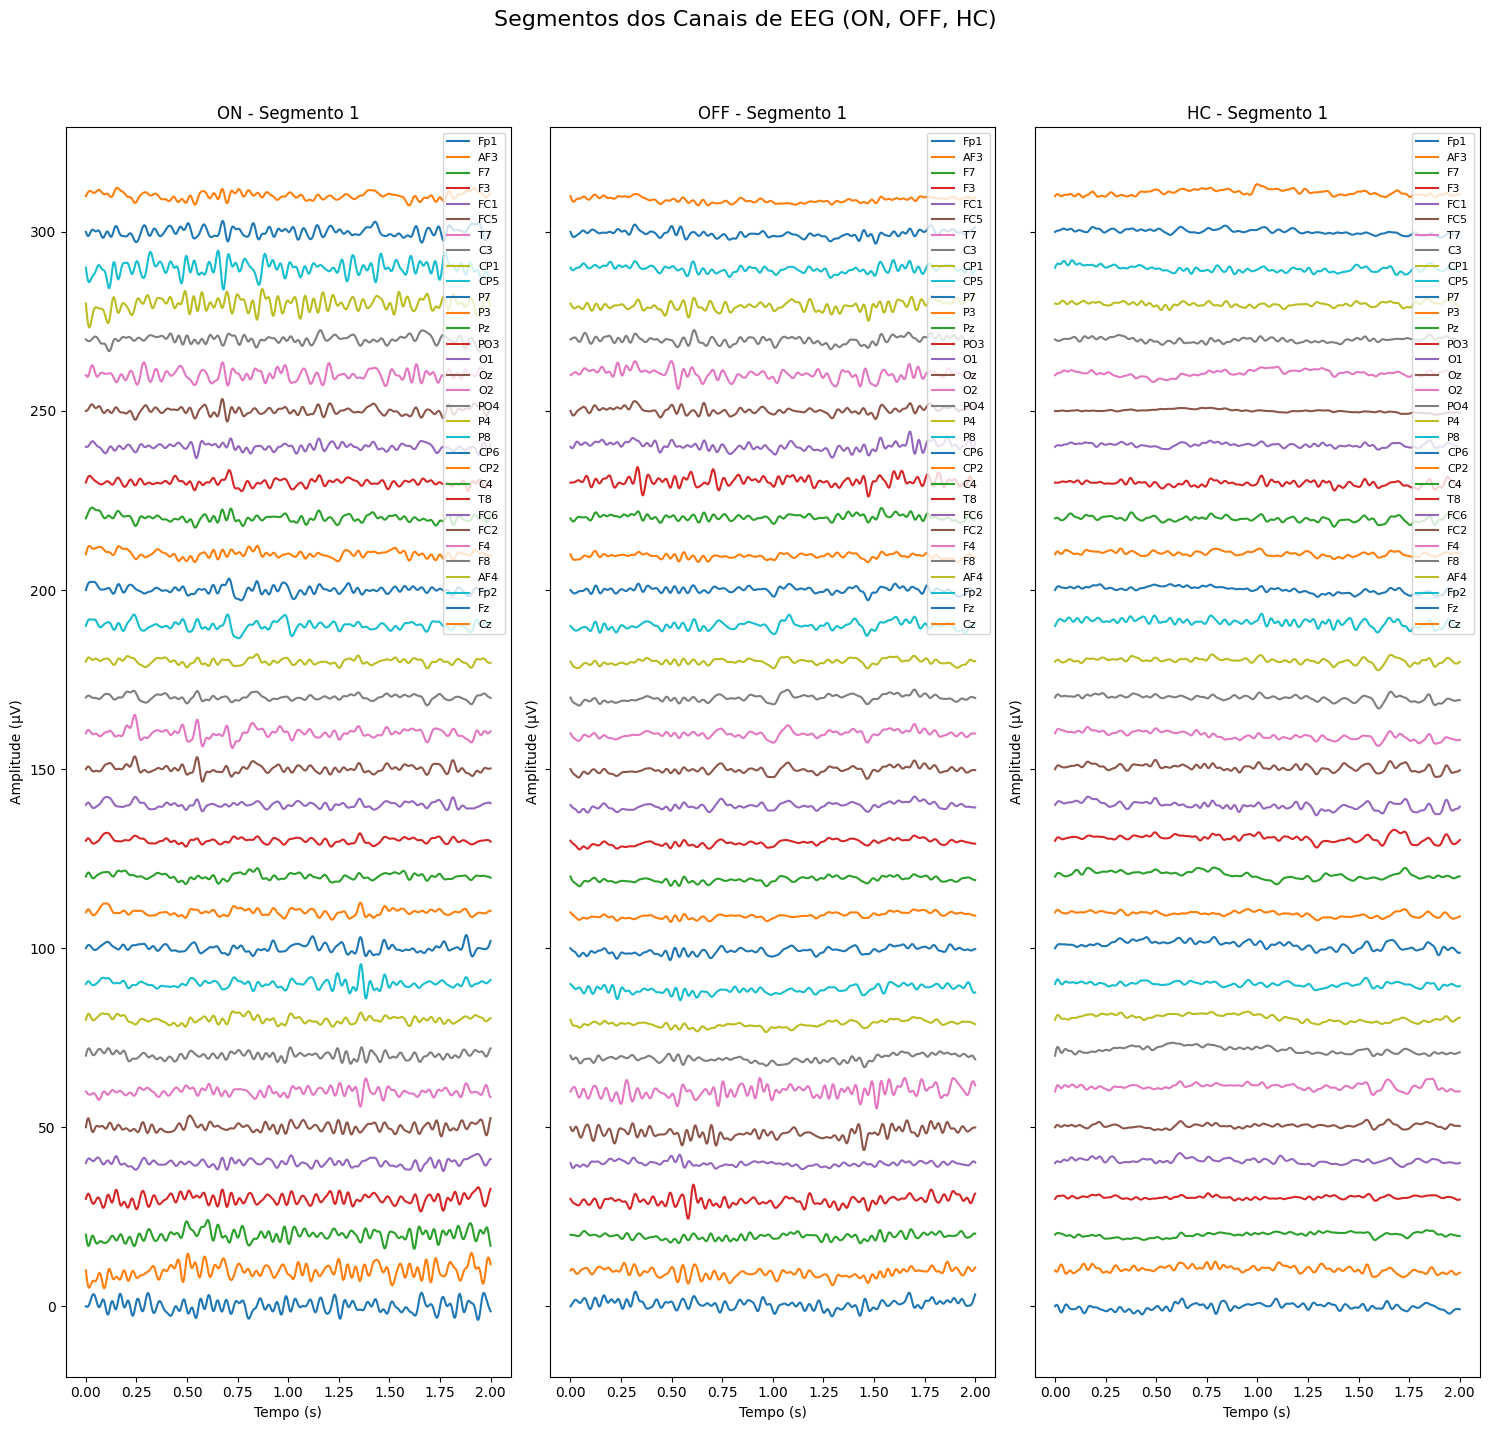

Figura salva em: /mnt/data/segmentos_eeg_reais_raw.png


In [51]:

# Nomes reais dos canais (já obtidos de raw.info['ch_names'])
nomes_canais = [
    'Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
    'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8',
    'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2',
    'Fz', 'Cz'
]

# Exemplo de estrutura de pacientes
pacientes = {
    "ON": dados_segmentados["sub-pd6_on"],  # Substitua com seus dados reais
    "OFF": dados_segmentados["sub-pd6_off"],  # Substitua com seus dados reais
    "HC": dados_segmentados["sub-hc10_hc"]  # Substitua com seus dados reais
}

# Ajustando para visualizar todos os canais e mais segmentos
n_canais = len(nomes_canais)  # Total de canais disponíveis no arquivo
n_segmentos = 1  # Visualizar apenas 1 segmento por classe

# Criar o gráfico novamente
fig, axes = plt.subplots(n_segmentos, len(pacientes), figsize=(15, 15), sharex=True, sharey=True)

# Garantir que `axes` seja uma matriz bidimensional mesmo com 1 segmento
if n_segmentos == 1:
    axes = np.expand_dims(axes, axis=0)

for col, (classe, segmentos) in enumerate(pacientes.items()):
    for row in range(n_segmentos):
        # Selecionar o segmento
        segmento = segmentos[row, :n_canais, :]  # Seleciona os canais e amostras do segmento

        # Criar vetor de tempo
        tempo = np.linspace(0, segmento.shape[1] / sfreq, segmento.shape[1])

        # Plotar cada canal do segmento
        for canal in range(segmento.shape[0]):
            axes[row, col].plot(tempo, segmento[canal, :] + canal * 10, label=nomes_canais[canal])  # Deslocamento para visualização

        # Ajustar título e eixos
        axes[row, col].set_title(f"{classe} - Segmento {row + 1}")
        axes[row, col].set_xlabel("Tempo (s)")
        axes[row, col].set_ylabel("Amplitude (μV)")

        # Adicionar legenda apenas no primeiro segmento de cada classe
        if row == 0:
            axes[row, col].legend(loc="upper right", fontsize=8)

# Ajustar layout e salvar a figura
fig.suptitle("Segmentos dos Canais de EEG (ON, OFF, HC)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Salvar a figura
fig_path = "/mnt/data/segmentos_eeg_reais_raw.png"
plt.savefig(fig_path, dpi=300)  # Salvar com alta qualidade
plt.show()

# Informar o caminho do arquivo salvo
print(f"Figura salva em: {fig_path}")




In [43]:
output_dir = "segmentos_plotados"
os.makedirs(output_dir, exist_ok=True)

# Plotar e salvar gráficos dos segmentos
for participant_id, segments in dados_segmentados.items():
    print(f"Plotando segmentos para {participant_id}...")
    num_segments = min(3, segments.shape[0])  # Mostrar até 3 segmentos
    for i in range(num_segments):
        plt.figure(figsize=(10, 4))
        plt.plot(segments[i, 0, :])  # Plotar apenas o primeiro canal
        plt.title(f"{participant_id} - Segmento {i+1}")
        plt.xlabel("Tempo (amostras)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        # Salvar o gráfico
        output_path = os.path.join(output_dir, f"{participant_id}_segmento_{i+1}.png")
        plt.savefig(output_path)
        plt.close()
        print(f"Gráfico salvo em: {output_path}")


Plotando segmentos para sub-hc1_hc...
Gráfico salvo em: segmentos_plotados/sub-hc1_hc_segmento_1.png
Gráfico salvo em: segmentos_plotados/sub-hc1_hc_segmento_2.png
Gráfico salvo em: segmentos_plotados/sub-hc1_hc_segmento_3.png
Plotando segmentos para sub-hc21_hc...
Gráfico salvo em: segmentos_plotados/sub-hc21_hc_segmento_1.png
Gráfico salvo em: segmentos_plotados/sub-hc21_hc_segmento_2.png
Gráfico salvo em: segmentos_plotados/sub-hc21_hc_segmento_3.png
Plotando segmentos para sub-hc24_hc...
Gráfico salvo em: segmentos_plotados/sub-hc24_hc_segmento_1.png
Gráfico salvo em: segmentos_plotados/sub-hc24_hc_segmento_2.png
Gráfico salvo em: segmentos_plotados/sub-hc24_hc_segmento_3.png
Plotando segmentos para sub-pd12_off...
Gráfico salvo em: segmentos_plotados/sub-pd12_off_segmento_1.png
Gráfico salvo em: segmentos_plotados/sub-pd12_off_segmento_2.png
Gráfico salvo em: segmentos_plotados/sub-pd12_off_segmento_3.png
Plotando segmentos para sub-pd12_on...
Gráfico salvo em: segmentos_plotados/

## Treino e Teste

In [33]:
# Configurar o dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Função para combinar dados e rótulos para HC, OFF e ON
def preparar_dados_segmentados(dados_segmentados):
    X = []
    y = []
    for participant_id, segmentos in dados_segmentados.items():
        if "hc" in participant_id:
            label = 0  # HC
        elif "off" in participant_id:
            label = 1  # OFF
        elif "on" in participant_id:
            label = 2  # ON
        else:
            raise ValueError(f"Rótulo desconhecido para o participante {participant_id}")

        X.append(segmentos)
        y.extend([label] * segmentos.shape[0])

    X = np.concatenate(X, axis=0)  # Combinar todos os segmentos
    y = np.array(y)  # Criar array de rótulos
    return X, y

# Preparar os dados segmentados
X, y = preparar_dados_segmentados(dados_segmentados)

# Dividir os dados em 90% treino e 10% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Exibir tamanhos dos conjuntos
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

# Converter para tensores PyTorch e transferir para o dispositivo
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Criar TensorDataset e DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Exibir informações dos DataLoaders
print(f"Número de batches - Treino: {len(train_loader)}, Teste: {len(test_loader)}")

Usando dispositivo: cuda
Treino: (10224, 32, 512), Teste: (1136, 32, 512)
Número de batches - Treino: 320, Teste: 36


## Modelo Transformer para classficação



In [34]:

# Classe PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        if x.size(1) > self.encoding.size(1):
            raise ValueError(
                f"Comprimento da entrada ({x.size(1)}) excede o máximo permitido ({self.encoding.size(1)}). "
                "Ajuste `max_len` na PositionalEncoding."
            )
        return x + self.encoding[:, :x.size(1), :].to(x.device)

# Modelo Transformer para EEG
class TransformerEEG(nn.Module):
    def __init__(self, n_channels, n_classes, seq_len, d_model=128, nhead=8, num_layers=3, dim_feedforward=256, dropout=0.3):
        super(TransformerEEG, self).__init__()
        self.input_proj = nn.Linear(n_channels, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.input_proj(x.transpose(1, 2))  # Projeção dos canais
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pooling global
        x = self.fc(x)
        return x

# Configuração do modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = 1024
n_classes = 3
model = TransformerEEG(
    n_channels=32,
    n_classes=n_classes,
    seq_len=seq_len,
    d_model=128,
    nhead=8,
    num_layers=3,
    dim_feedforward=256,
    dropout=0.3
).to(device)

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Treinamento
n_epochs = 15
train_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    print(f"Época {epoch + 1}/{n_epochs} - Loss Treino: {train_loss:.4f}")

# Avaliação no conjunto de teste
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = correct / total
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))

Época 1/15 - Loss Treino: 1.0237
Época 2/15 - Loss Treino: 0.6912
Época 3/15 - Loss Treino: 0.5220
Época 4/15 - Loss Treino: 0.4011
Época 5/15 - Loss Treino: 0.2904
Época 6/15 - Loss Treino: 0.2193
Época 7/15 - Loss Treino: 0.1598
Época 8/15 - Loss Treino: 0.1048
Época 9/15 - Loss Treino: 0.0857
Época 10/15 - Loss Treino: 0.0506
Época 11/15 - Loss Treino: 0.0634
Época 12/15 - Loss Treino: 0.0468
Época 13/15 - Loss Treino: 0.0467
Época 14/15 - Loss Treino: 0.0301
Época 15/15 - Loss Treino: 0.0397
Acurácia no conjunto de teste: 0.9023

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       384
           1       0.86      0.92      0.89       376
           2       0.93      0.89      0.90       376

    accuracy                           0.90      1136
   macro avg       0.90      0.90      0.90      1136
weighted avg       0.90      0.90      0.90      1136



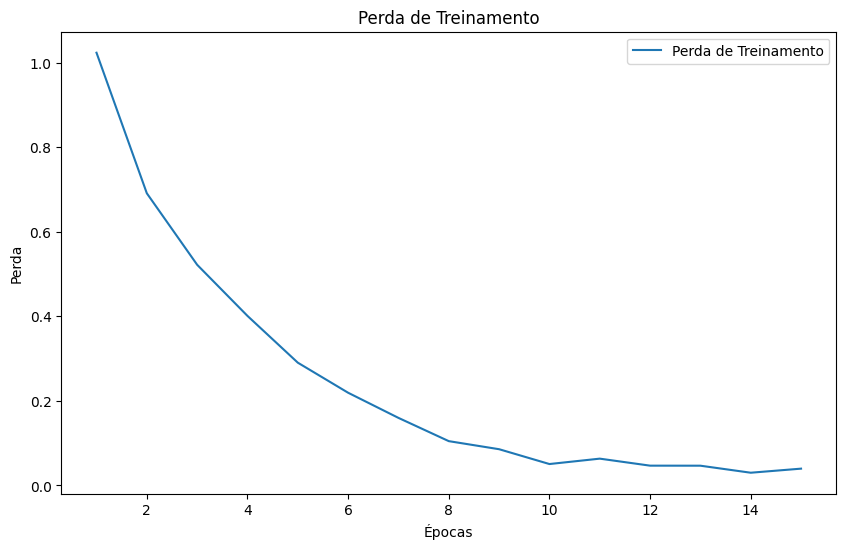

In [35]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Perda de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Perda de Treinamento')
plt.legend()
plt.show()



### Validação do modelo

#### Teste

Acurácia no conjunto de teste: 0.9023

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       384
           1       0.86      0.92      0.89       376
           2       0.93      0.89      0.90       376

    accuracy                           0.90      1136
   macro avg       0.90      0.90      0.90      1136
weighted avg       0.90      0.90      0.90      1136



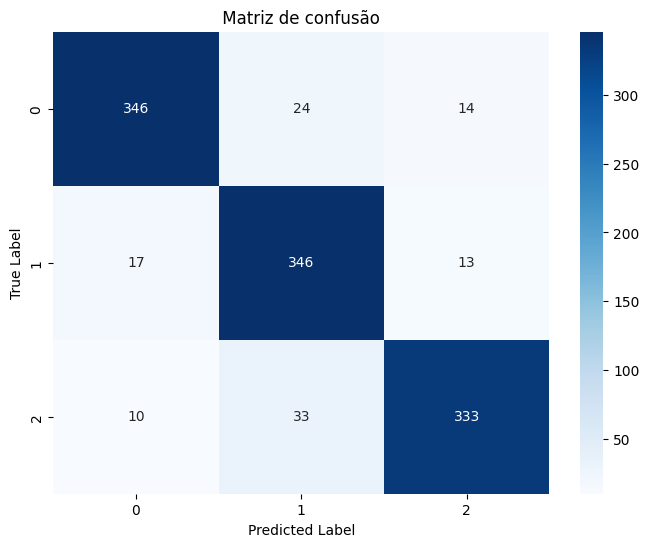

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Avaliação no conjunto de teste
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

# Acurácia
accuracy = correct / total
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_true, y_pred)


# Plotar a Matriz de Confusão
classes = np.unique(y_true)  # Nomes das classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(" Matriz de confusão ")
plt.show()


#### Treino

Acurácia no conjunto de treinamento: 0.9969

Relatório de Classificação no Conjunto de Treinamento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3458
           1       0.99      1.00      1.00      3385
           2       1.00      0.99      1.00      3381

    accuracy                           1.00     10224
   macro avg       1.00      1.00      1.00     10224
weighted avg       1.00      1.00      1.00     10224



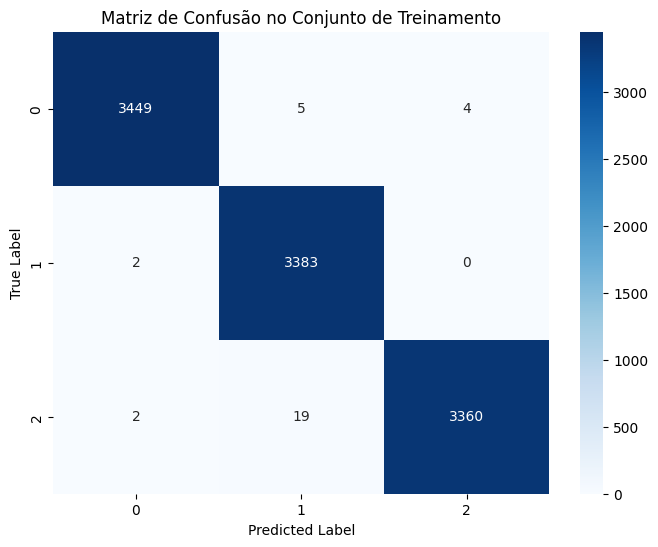

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Avaliação no conjunto de treinamento
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

# Acurácia no conjunto de treinamento
accuracy = correct / total
print(f"Acurácia no conjunto de treinamento: {accuracy:.4f}")

# Relatório de classificação
print("\nRelatório de Classificação no Conjunto de Treinamento:")
print(classification_report(y_true, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotar a Matriz de Confusão
classes = np.unique(y_true)  # Nomes das classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusão no Conjunto de Treinamento")
plt.show()

## Captum

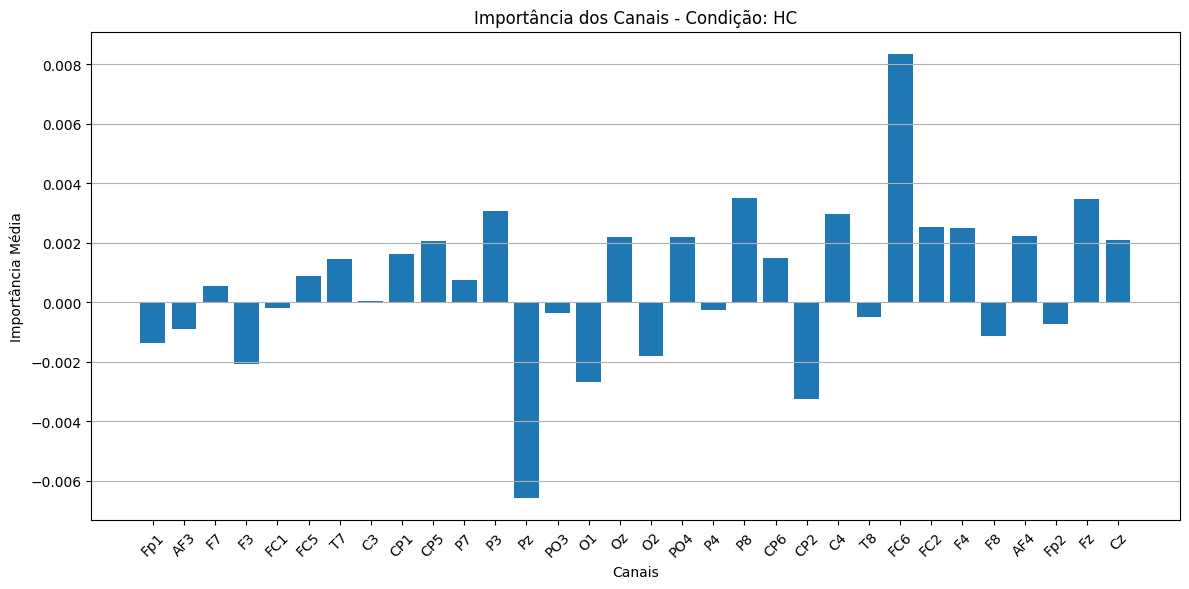

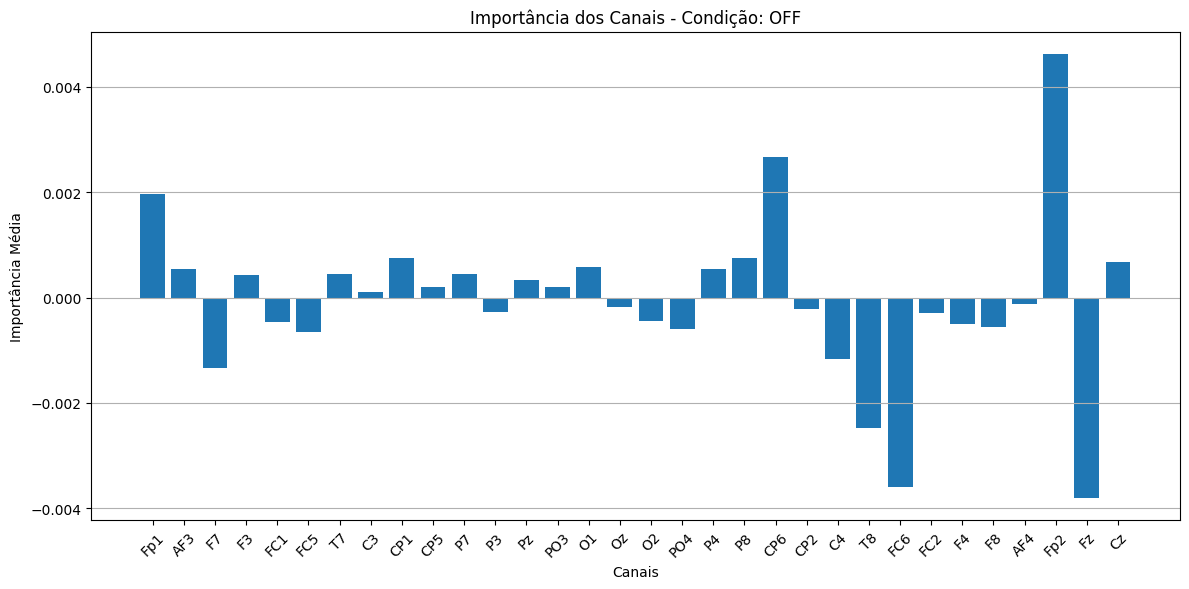

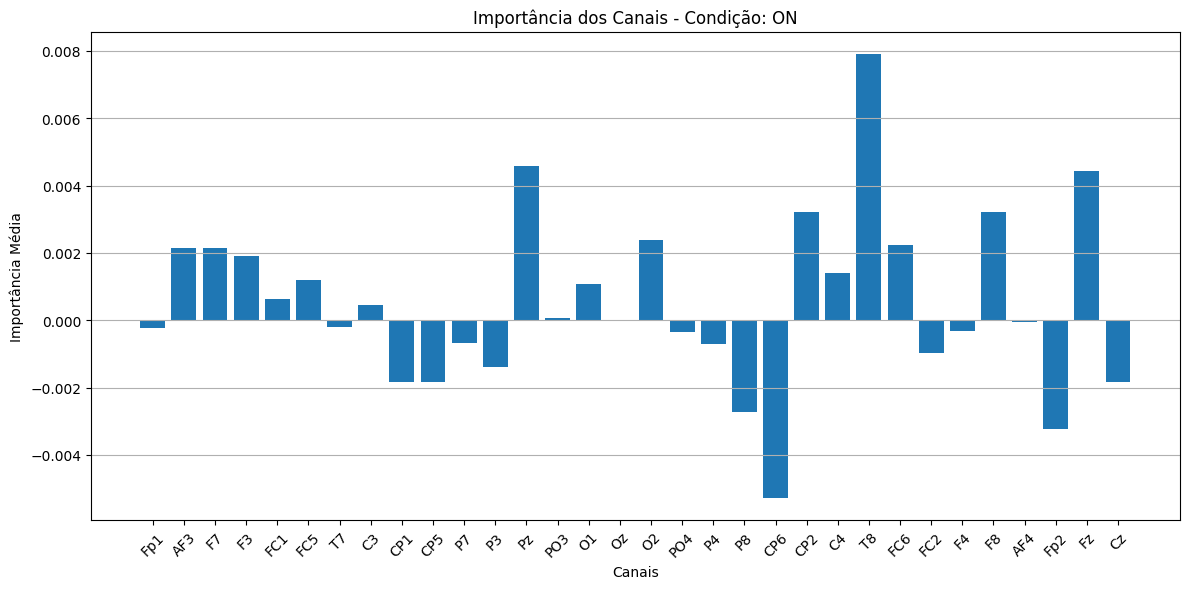

In [40]:


# Certifique-se de que o modelo está em modo de avaliação
model.eval()

# Função para calcular as importâncias com Integrated Gradients
def calcular_importancias_ig(model, X_test, y_test):
    ig = IntegratedGradients(model)
    all_importances = []

    for i in range(X_test.shape[0]):
        input_tensor = X_test[i].unsqueeze(0)  # Adicionar dimensão de batch
        target = y_test[i].unsqueeze(0)  # Adicionar dimensão de batch
        attributions, _ = ig.attribute(input_tensor, target=target, return_convergence_delta=True)
        all_importances.append(attributions.squeeze(0).mean(dim=1).cpu().numpy())  # Média por canal

    return np.array(all_importances)

# Cálculo das importâncias
all_importances = calcular_importancias_ig(model, X_test_tensor, y_test_tensor)

# Nomes dos canais
try:
    nomes_canais = raw.info['ch_names']
except NameError:
    nomes_canais = [
        'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
        'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2',
        'CP1', 'CP2', 'PO1', 'PO2', 'AFz', 'TP1', 'TP2', 'FT1', 'FT2',
        'FCz', 'CPz', 'POz'
    ]

# Função para calcular a média das importâncias por condição
def separar_por_condicao(importancias, y_test, num_canais):
    medias_importancias = {'HC': np.zeros(num_canais),
                           'OFF': np.zeros(num_canais),
                           'ON': np.zeros(num_canais)}

    contadores = {'HC': 0, 'OFF': 0, 'ON': 0}

    for i, classe in enumerate(y_test):
        if classe == 0:  # HC
            medias_importancias['HC'] += importancias[i]
            contadores['HC'] += 1
        elif classe == 1:  # OFF
            medias_importancias['OFF'] += importancias[i]
            contadores['OFF'] += 1
        elif classe == 2:  # ON
            medias_importancias['ON'] += importancias[i]
            contadores['ON'] += 1

    # Normalizar pelas contagens
    for key in medias_importancias:
        if contadores[key] > 0:
            medias_importancias[key] /= contadores[key]

    return medias_importancias

# Calcular as médias das importâncias por condição
medias_importancias = separar_por_condicao(all_importances, y_test_tensor.cpu().numpy(), num_canais=32)

# Gerar gráficos com os nomes reais dos canais
for condicao, importancias in medias_importancias.items():
    plt.figure(figsize=(12, 6))
    plt.bar(nomes_canais, importancias)
    plt.title(f"Importância dos Canais - Condição: {condicao}")
    plt.xlabel("Canais")
    plt.ylabel("Importância Média")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()



#### Mapas topográficos

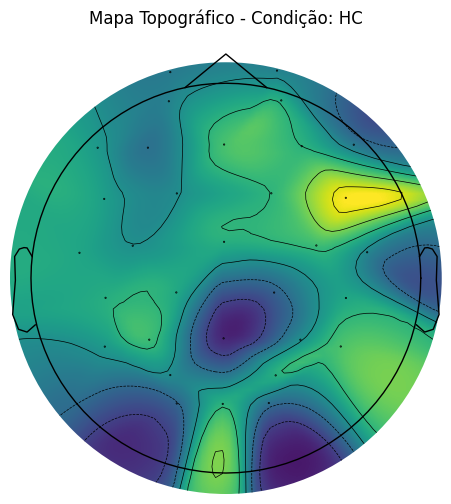

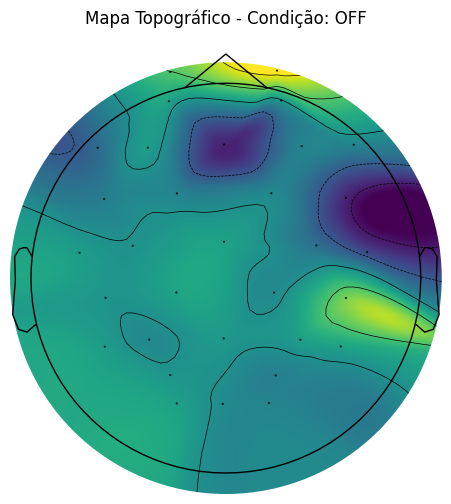

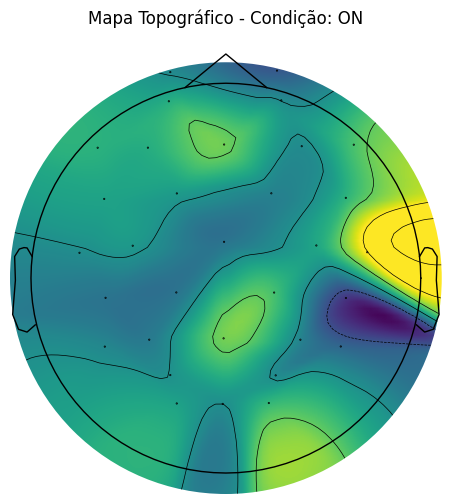

In [41]:


# Criar o info com os nomes dos canais e localização
montage = mne.channels.make_standard_montage("standard_1020")  # Alterar conforme necessário
info = mne.create_info(ch_names=nomes_canais, sfreq=256, ch_types="eeg")  # Frequência de amostragem arbitrária
info.set_montage(montage)

# Função para gerar mapas topográficos
def gerar_mapas_topograficos(importancias_por_condicao, nomes_canais, info):
    for condicao, importancias in importancias_por_condicao.items():
        # Mapear importâncias para os canais
        evoked = mne.EvokedArray(np.expand_dims(importancias, axis=1), info, tmin=0)  # tmin define o tempo inicial

        # Plotar mapa topográfico
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, cmap="viridis", show=False)
        ax.set_title(f"Mapa Topográfico - Condição: {condicao}")
        plt.show()

# Gerar mapas topográficos
gerar_mapas_topograficos(medias_importancias, nomes_canais, info)